In [125]:
# Let's code it up, preamble first. 

import numpy as np # basic vector/matrix math
import matplotlib.pyplot as plt # plotting and illustrations 
import seaborn as sns # advanced plotting and illustrations. 
import pandas as pd # data loading, saving, and general data manipulation. 
import scipy.stats as stats # inter alia, statistical distributions, functions and relevant objects.
import scipy.optimize as optimize 
import torch # ML/AI model's and general optimization 

# STA 2453 Lab 1 Submission

This lab notebook must be completed in the appropriate time during class and invigilated by the instructor. There are _ questions, you must add both this notebook, and another generated .py file to the PR. 

Once the PR is in place, please tag both me and the TA in it. So in the end you will have two files. 

- `STA2453-Lab-1.ipynb`
- `STA2453-Lab-1.py`

Both of these are needed for a good submission. 



# Case Study: Does God Hate Rich People? 


## Introduction 

Extreme weather events in the U.S. are regularly tracked by the National Oceanic and Atomspheric Administration (NOAA).

The NCDC Storm Events database is provided by the National Weather Service (NWS) and contain statistics on personal injuries and damage estimates. (ref. gov.noaa.ncdc:C00510). 

## The question is, are high-income or low-income households more susceptible to extreme weather events? 

The US Household Income dataset provided by Golden Oak Research Group contains 32,000 records on US Household Income Statistics & Geo Locations. The dataset originally developed for real estate and business investment research. Income is a vital element when determining both quality and socioeconomic features of a given geographic location. (ref. Golden Oak Research Group, LLC. “U.S. Income Database Kaggle”. Publication: 5, August 2017.)


The two files listed here: 

## Storm Weather Event Data
`https://raw.githubusercontent.com/nikpocuca/sta2453-2022.github.io/master/StormEvents_locations-ftp_v1.0_d2014_c20180718.csv`


## Golden Oak Research Group Data
`https://raw.githubusercontent.com/nikpocuca/sta2453-2022.github.io/master/kaggle_income_clean.csv`

In [126]:
# Load data
storm_events_data = pd.read_csv('https://raw.githubusercontent.com/nikpocuca/sta2453-2022.github.io/master/StormEvents_locations-ftp_v1.0_d2014_c20180718.csv')
income_data = pd.read_csv('https://raw.githubusercontent.com/nikpocuca/sta2453-2022.github.io/master/kaggle_income_clean.csv')

In [127]:
# glimpse data
storm_events_data.head()

,YEARMONTH,EPISODE_ID,EVENT_ID,LOCATION_INDEX,RANGE,AZIMUTH,LOCATION,LATITUDE,LONGITUDE,LAT2,LON2
0,201405,84460,509925,1,2.0,N,BAKERSFIELD,30.9090,-102.2800,3054540,10216800
1,201405,84460,509932,1,2.0,NW,STILES,31.4205,-101.6040,3125230,10136240
2,201405,84460,509935,1,29.0,NNE,SANDERSON,30.5378,-102.2139,3032268,10212834
3,201405,84460,509938,1,0.0,N,IRAAN,30.9200,-101.8800,3055200,10152800
4,201405,84460,509939,1,0.0,N,IRAAN,30.9200,-101.8800,3055200,10152800


In [128]:
income_data.head()

,Unnamed: 0,Unnamed: 0.1,id,State_Code,State_Name,State_ab,County,City,Place,Type,...,Zip_Code,Area_Code,ALand,AWater,Lat,Lon,Mean,Median,Stdev,sum_w
0,0,1,1011000,1,Alabama,AL,Mobile County,Chickasaw,Chickasaw city,City,...,36611,251,10894952,909156.0,30.771450,-88.079697,38773,30506,33101.0,1638.260513
1,1,2,1011010,1,Alabama,AL,Barbour County,Louisville,Clio city,City,...,36048,334,26070325,23254.0,31.708516,-85.611039,37725,19528,43789.0,258.017685
2,2,3,1011020,1,Alabama,AL,Shelby County,Columbiana,Columbiana city,City,...,35051,205,44835274,261034.0,33.191452,-86.615618,54606,31930,57348.0,926.031000
3,3,4,1011030,1,Alabama,AL,Mobile County,Satsuma,Creola city,City,...,36572,251,36878729,2374530.0,30.874343,-88.009442,63919,52814,47707.0,378.114619
4,4,5,1011040,1,Alabama,AL,Mobile County,Dauphin Island,Dauphin Island,Town,...,36528,251,16204185,413605152.0,30.250913,-88.171268,77948,67225,54270.0,282.320328



## Cleaning Data 

We want to take only the continental US data, so that involves the following: 

- `20 < Lat < 50`
- `Lon > -140`


Furthermore we want to create two dataframes, one for poor people, one for rich people. According to the US Census Bureau, a person who's average income is below \$25k is considered below the poverty line, while a person exceeding \$100k is considered wealthy. 

Create two dataframes called `rich_df` and `poor_df` for analysis after cleaning out for strictly continental US. 


In [129]:
# clean df. 
cleaned_storm_data = storm_events_data.loc[(storm_events_data['LONGITUDE'] > -140) & 
                                        (storm_events_data['LATITUDE'] > 20) & 
                                        (storm_events_data['LATITUDE'] < 50)].reset_index(drop=True)

cleaned_income_data = income_data.loc[(income_data['Lon'] > -140) & 
                                    (income_data['Lat'] > 20) & 
                                    (income_data['Lat'] < 50)].reset_index(drop=True)

In [130]:
# rich/poor segmentation
rich_seg = cleaned_income_data[cleaned_income_data['Mean'] > 100000].reset_index(drop=True)
poor_seg = cleaned_income_data[cleaned_income_data['Mean'] < 25000].reset_index(drop=True)

## Calculate Nearest Distance between Points

For each household we need to calculate the nearest severe weather event. We should write a function to do this. Let $x$,$y$ denote longitude and latitude respectively. then for some Houshold $H$, we should calculate the distance to all the severe weather events $E$ longitude and latitude. 


$$ d_{H,E} = 110.574 \times \sqrt{(x_H - x_E)^2 + (y_H - y_E)^2} $$

Basically we are getting a eucledian distance to each severe weather event, and then multiplying by a constant to convert to km's for sanity. Then we want to find the distance to the nearest event so we take the minimum... 

$$ d_{min} = \text{argmin}\{d_{H,E_1}, d_{H,E_2}, \dots, d_{H,E_n} \} $$ 


Do this for every household, and plot the results in a histogram for both rich/poor households.  

In [131]:
rich_longtitude = rich_seg['Lon']
rich_latitude = rich_seg['Lat']

poor_longtitude = poor_seg['Lon']
poor_latitude = poor_seg['Lat']

weather_long_lat = []
for index in range(cleaned_storm_data.shape[0]):
  weather_long_lat.append((cleaned_storm_data['LONGITUDE'][index], 
                          cleaned_storm_data['LATITUDE'][index]))

In [132]:
# calculate min distances for rich people
rich_n_row = rich_seg.shape[0]
rich_long_lat = []
for index in range(rich_n_row):
  rich_long_lat.append( (rich_longtitude[index], rich_latitude[index]) )

rich_min_distances = []

for item in rich_long_lat:
  distances = []
  for row in weather_long_lat:
    weather_long, weather_lat = row
    distance = 110.574 * np.sqrt( (item[0] - weather_long)**2 + (item[1] - weather_lat)**2)
    distances.append(distance)
  rich_min_distances.append(min(distances))

In [133]:
# calculate min distances for poor people
poor_n_row = poor_seg.shape[0]
poor_long_lat = []
for index in range(poor_n_row):
  poor_long_lat.append( (poor_longtitude[index], poor_latitude[index]) )

poor_min_distances = []
for item in poor_long_lat:
  distances = []
  for row in weather_long_lat:
    weather_long, weather_lat = row
    distance = 110.574 * np.sqrt( (item[0] - weather_long)**2 + (item[1] - weather_lat)**2)
    distances.append(distance)
  poor_min_distances.append(min(distances))

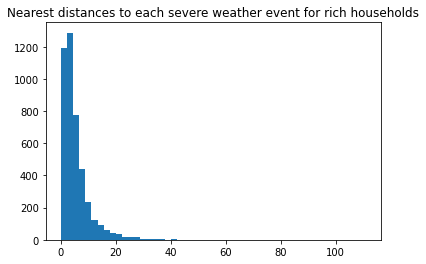

In [134]:
# plot rich people histogram, make bins at least 50, comment on the plot.
plt.hist(rich_min_distances, bins=50);
plt.title("Nearest distances to each severe weather event for rich households");

Comment: The nearest distances to each severe weather event for rich households have a main range from 0 to 60, mostly with a value less than 20, and with some outliers lying between 100 and 120.

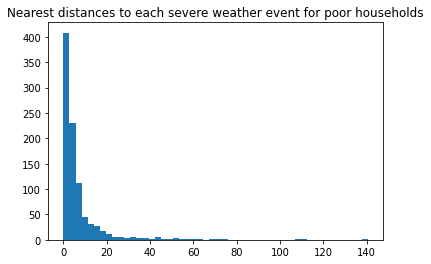

In [135]:
# plot poor people histogram, make bins at least 50, comment on the plot
plt.hist(poor_min_distances, bins=50);
plt.title("Nearest distances to each severe weather event for poor households");

Comment: The nearest distances to each severe weather event for poor households have a main range from 0 to 80, mostly with a value less than 20, and with some outliers lying between 100 and 140. Moreover, comparing the plots for rich and poor households, poor households are having a longer minimum distance for some severe weather events. This may hlep us to have a guess that poor households may be less likely to be hit by the severe weather storm. \
PS: Actually I've got another concern. The sample sizes are different for rich and poor households, which might be a biased factor.

# Distributional Characteristic Statistics

In the following cells please perform some statistical analysis and determine whether rich people are more likely to be struck by extreme weather events, or, poor people are more likely. The methods/statistics presented in week one in class are extremely useful.  

You should also find the difference of mean pooled t-test useful in this case but you must justify your assumptions for using it. You can use any python libraries or functions as well as go on stack overflow. You should also use the functions written up in the previous class [here](https://colab.research.google.com/drive/1L1Kx8qoHCY3yjuYg2tE4W61xu79xG7lJ?usp=sharing).

$$ t = \frac{ \bar{X}_R - \bar{X}_P}{ s_T \sqrt{\frac{1}{n_R} + \frac{1}{n_P}}  } $$

where, 
$$ s_T = \sqrt{ \frac{(n_R - 1)s_R + (n_P -1)s_P}{n_R + n_P - 2}  }  $$

Hint: Use the following function `stats.ttest_ind` and adjust the appropriate setting such that you test wether $\bar{X}_R > \bar{X}_P$, or vice versa.

Hint-2: Use the functions from the previous week's notebook. 

Caveat: Keep resampling techniques under 500 scenarios (in class we used 1000).


### Please write your conclusion at the end wether Rich or Poor people are more likely to get hit by a severe weather storm. 

In [136]:
t_test = stats.ttest_ind(rich_min_distances, poor_min_distances, alternative='greater')
theoretical_t, theoretical_p = t_test[0], t_test[1]
theoretical_p

0.9999999999947364

In [137]:
total_distances = rich_min_distances + poor_min_distances
n_scenarios = 500
t_statistics = np.zeros(n_scenarios)
for i in range(n_scenarios):
  resample = np.random.choice(total_distances, size=len(total_distances))
  t_statistics[i] = stats.ttest_ind(resample[:len(rich_min_distances)], 
                                    resample[len(rich_min_distances):], 
                                    alternative='greater')[0]

p_value_resampling = np.mean(abs(t_statistics) >= abs(theoretical_t))
p_value_resampling

0.0

Under the assumption of the two populations having identical variances, I calculated the T-test for the means of two independent samples (nearest distances to each severe weather event for rich and poor households), with a null hypothesis $H_0$: $\bar{X}_R < \bar{X}_P$, with an alternative hypothesis $H_1$: $\bar{X}_R \geq \bar{X}_P$. Since the theoratical p-value is much lager than the significance level of $5\%$, so we cannot reject the null hypothesis, which means the average nearest distances to each severe weather event for rich households is less than that of poor households. That implies that rich households are more likely to get hit by a severe weather storm.

Morover, we did resampling among the rich and poor samples and did the same two-sample t-test again, ending up with a resampling p-value of 0. Thus, we can reject the null hypotheis after the resampling. This is mainly because that, after resampling, the rich and poor smaples are mixed and there tends to be no difference between the expected values of the nearst values among two groups. 